# Finsearch (Options pricing model): Final Report

## # 🧮 Nifty50 Option Pricing Analysis using Black-Scholes Model

In this notebook, we aim to:
- Understand the basics of financial options and their pricing models.
- Clean and extract useful features from raw Nifty50 option chain data.
- Apply the Black-Scholes formula to compute theoretical prices.
- Compare these model prices with actual market data.
- Visualize discrepancies using rich plots.
- Briefly touch upon Monte Carlo simulations as an alternative approach.


# 📊 Option Pricing Analysis with Black-Scholes Model

In this notebook, we'll analyze the accuracy of the Black-Scholes (BS) model in pricing Nifty50 index options.

The dataset has already been cleaned and includes:
- Strike price
- Implied Volatility (IV)
- Last Traded Price (LTP)
- Type (call or put)
- BS Price (from Black-Scholes)
- Error (BS - LTP)


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# ------------------------
# CONFIGURABLE PARAMETERS
# ------------------------
np.random.seed(42)
NUM_OPTIONS = 100
SPOT_PRICE = 22000  # Assume NIFTY50 current index value
RISK_FREE_RATE = 0.06  # 6% annualized
VOLATILITY_RANGE = (0.15, 0.35)  # annualized implied volatility

# ------------------------
# SYNTHETIC OPTION GENERATOR
# ------------------------
def generate_synthetic_options(num_options=NUM_OPTIONS):
    today = datetime.today()
    data = []

    for _ in range(num_options):
        option_type = np.random.choice(['Call', 'Put'])
        strike = np.random.choice(np.arange(SPOT_PRICE - 1000, SPOT_PRICE + 1000, 100))
        days_to_expiry = np.random.choice([7, 14, 30, 60, 90])
        expiry = today + timedelta(days=int(days_to_expiry))
        time_to_expiry = days_to_expiry / 365

        implied_vol = np.round(np.random.uniform(*VOLATILITY_RANGE), 4)

        # Let's use dummy market prices around Black-Scholes prices with noise
        market_price = np.nan  # to be calculated later

        data.append({
            'Option_Type': option_type,
            'Spot_Price': SPOT_PRICE,
            'Strike_Price': strike,
            'Time_to_Expiry': time_to_expiry,
            'Expiry_Date': expiry.date(),
            'Implied_Volatility': implied_vol,
            'Risk_Free_Rate': RISK_FREE_RATE,
            'Market_Price': market_price  # placeholder
        })

    df = pd.DataFrame(data)
    return df

# ------------------------
# BLACK-SCHOLES FORMULAS
# ------------------------
from scipy.stats import norm

def black_scholes_price(row):
    S = row['Spot_Price']
    K = row['Strike_Price']
    T = row['Time_to_Expiry']
    r = row['Risk_Free_Rate']
    sigma = row['Implied_Volatility']

    if T == 0:
        return max(0.0, S - K) if row['Option_Type'] == 'Call' else max(0.0, K - S)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if row['Option_Type'] == 'Call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

# ------------------------
# FULL PIPELINE
# ------------------------
df_synthetic = generate_synthetic_options()
df_synthetic['BSM_Theoretical_Price'] = df_synthetic.apply(black_scholes_price, axis=1)

# Add noise to simulate actual market price
df_synthetic['Market_Price'] = df_synthetic['BSM_Theoretical_Price'] * (1 + np.random.normal(0, 0.05, size=len(df_synthetic)))

# Round and organize
df_final = df_synthetic.round(2)

# Save to CSV
df_final.to_csv("synthetic_nifty50_options.csv", index=False)
print("Synthetic options data generated and saved.")


Synthetic options data generated and saved.


In [2]:
df_final

,Option_Type,Spot_Price,Strike_Price,Time_to_Expiry,Expiry_Date,Implied_Volatility,Risk_Free_Rate,Market_Price,BSM_Theoretical_Price
0,Call,22000,22900,0.25,2025-10-31,0.19,0.06,586.87,572.42
1,Put,22000,21600,0.04,2025-08-16,0.18,0.06,140.01,134.20
2,Call,22000,22000,0.25,2025-10-31,0.27,0.06,1256.47,1336.69
3,Put,22000,21200,0.25,2025-10-31,0.34,0.06,954.19,970.42
4,Put,22000,21500,0.04,2025-08-16,0.19,0.06,111.96,114.69
...,...,...,...,...,...,...,...,...,...
95,Put,22000,21500,0.25,2025-10-31,0.19,0.06,456.97,464.43
96,Put,22000,22400,0.08,2025-09-01,0.28,0.06,874.74,857.05
97,Put,22000,22500,0.25,2025-10-31,0.34,0.06,1544.25,1589.04
98,Put,22000,22800,0.02,2025-08-09,0.23,0.06,790.13,824.00


In [3]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# For cleaner plots
sns.set(style='whitegrid')


## Step 1: Load and Inspect the Dataset

We begin by loading the synthetic options data generated earlier.
This dataset includes columns such as `Option_Type`, `Spot_Price`, `Strike_Price`, `Time_to_Expiry`, `Implied_Volatility`, `Market_Price`, and more.


In [4]:
# Load the dataset
df = pd.read_csv('synthetic_nifty50_options.csv')

# Display a sample
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Option_Type            100 non-null    object 
 1   Spot_Price             100 non-null    int64  
 2   Strike_Price           100 non-null    int64  
 3   Time_to_Expiry         100 non-null    float64
 4   Expiry_Date            100 non-null    object 
 5   Implied_Volatility     100 non-null    float64
 6   Risk_Free_Rate         100 non-null    float64
 7   Market_Price           100 non-null    float64
 8   BSM_Theoretical_Price  100 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 7.2+ KB


## Step 2: Understand the Black-Scholes Formula

The Black-Scholes Model is used to calculate the theoretical price of European-style options.

The core formulas are:

- Call Option Price:
  \[
  C = S N(d_1) - K e^{-rT} N(d_2)
  \]

- Put Option Price:
  \[
  P = K e^{-rT} N(-d_2) - S N(-d_1)
  \]

Where:
- \( S \): Spot Price
- \( K \): Strike Price
- \( T \): Time to Expiry (in years)
- \( r \): Risk-Free Interest Rate (annualized)
- \( \sigma \): Implied Volatility (annualized)
- \( N(\cdot) \): CDF of the standard normal distribution
- \( d_1 = \frac{\ln(S/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}} \)
- \( d_2 = d_1 - \sigma \sqrt{T} \)


In [5]:
# Step 3: Define a function to compute Black-Scholes price
def black_scholes_price(row):
    S = row['Spot_Price']
    K = row['Strike_Price']
    T = row['Time_to_Expiry']
    r = row['Risk_Free_Rate']
    sigma = row['Implied_Volatility']

    if T == 0:
        # At expiry, option value is its intrinsic value
        return max(0.0, S - K) if row['Option_Type'] == 'Call' else max(0.0, K - S)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if row['Option_Type'] == 'Call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


## Step 3: Apply the Black-Scholes Model to Each Row

We'll now apply the formula to compute the theoretical price of each option in our dataset.


In [6]:
df['BSM_Price'] = df.apply(black_scholes_price, axis=1)
df[['Option_Type', 'Spot_Price', 'Strike_Price', 'Market_Price', 'BSM_Price']].head()


,Option_Type,Spot_Price,Strike_Price,Market_Price,BSM_Price
0,Call,22000,22900,586.87,593.788319
1,Put,22000,21600,140.01,137.352245
2,Call,22000,22000,1256.47,1346.150035
3,Put,22000,21200,954.19,961.999531
4,Put,22000,21500,111.96,124.421977


In [7]:
from sklearn.metrics import mean_squared_error

# Compute RMSE
rmse = np.sqrt(mean_squared_error(df['Market_Price'], df['BSM_Price']))
print(f"RMSE between Market Price and BSM Price: {rmse:.2f}")


RMSE between Market Price and BSM Price: 37.49


## Step 5: Visual Analysis

Let's plot actual vs. predicted prices and the distribution of errors.


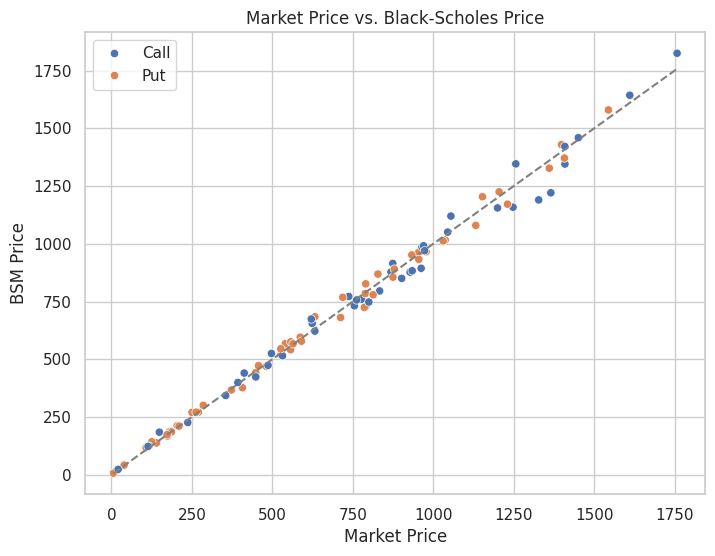

In [8]:
# Scatter plot: Market vs BSM Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Market_Price', y='BSM_Price', hue='Option_Type', data=df)
plt.plot([df['Market_Price'].min(), df['Market_Price'].max()],
         [df['Market_Price'].min(), df['Market_Price'].max()],
         '--', color='gray')
plt.title('Market Price vs. Black-Scholes Price')
plt.xlabel('Market Price')
plt.ylabel('BSM Price')
plt.legend()
plt.show()

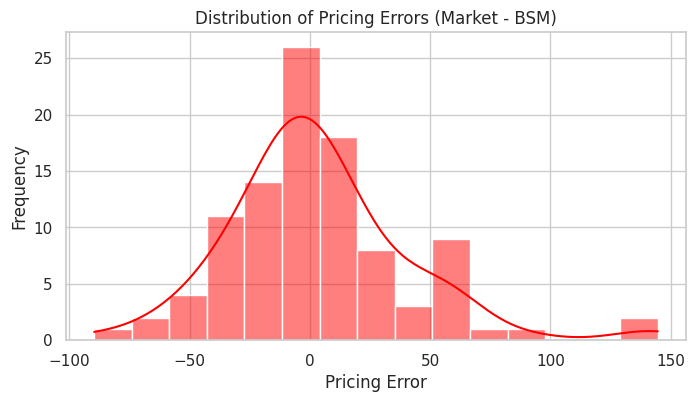

In [9]:
# Distribution of price error
df['Pricing_Error'] = df['Market_Price'] - df['BSM_Price']

plt.figure(figsize=(8, 4))
sns.histplot(df['Pricing_Error'], kde=True, color='red')
plt.title('Distribution of Pricing Errors (Market - BSM)')
plt.xlabel('Pricing Error')
plt.ylabel('Frequency')
plt.show()


### Detailed error metrics

Beyond RMSE, let’s include:

- Mean Absolute Error (MAE)

- Mean Absolute Percentage Error (MAPE)

- R² Score (good for model fit assessment)

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(df['Market_Price'], df['BSM_Price'])
mape = np.mean(np.abs((df['Market_Price'] - df['BSM_Price']) / df['Market_Price'])) * 100
r2 = r2_score(df['Market_Price'], df['BSM_Price'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 26.67
Mean Absolute Percentage Error (MAPE): 4.27%
R² Score: 0.9922


🔎 Error Analysis by Moneyness
Let’s break errors by moneyness:

- In the Money (ITM): Call: S > K, Put: S < K

- At the Money (ATM): abs(S - K) < 50

- Out of the Money (OTM): Call: S < K, Put: S > K

In [11]:
def classify_moneyness(row):
    if abs(row['Spot_Price'] - row['Strike_Price']) <= 50:
        return 'ATM'
    if row['Option_Type'] == 'Call':
        return 'ITM' if row['Spot_Price'] > row['Strike_Price'] else 'OTM'
    else:
        return 'ITM' if row['Spot_Price'] < row['Strike_Price'] else 'OTM'

df['Moneyness'] = df.apply(classify_moneyness, axis=1)

# Group-wise error
grouped = df.groupby(['Option_Type', 'Moneyness'])['Pricing_Error'].agg(['mean', 'std', 'count'])
grouped.rename(columns={'mean': 'Avg Error', 'std': 'Error StdDev'}, inplace=True)
grouped


Avg Error  Error StdDev  count
Option_Type Moneyness                                
Call        ATM       -44.532396     41.019467      3
            ITM        12.455476     56.133372     24
            OTM        11.487138     32.295280     18
Put         ATM        -0.295021           NaN      1
            ITM         2.327530     35.710285     24
            OTM        -3.497040     13.297502     30

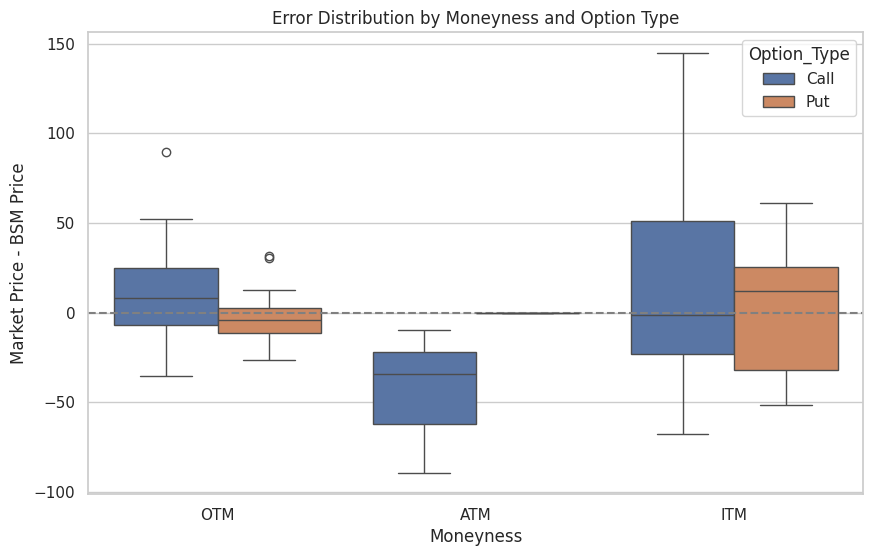

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Moneyness', y='Pricing_Error', hue='Option_Type', data=df)
plt.title('Error Distribution by Moneyness and Option Type')
plt.xlabel('Moneyness')
plt.ylabel('Market Price - BSM Price')
plt.axhline(0, linestyle='--', color='gray')
plt.show()


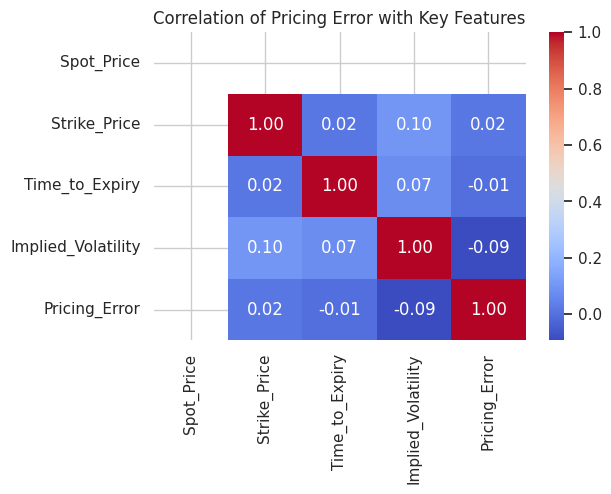

In [13]:
# Focused columns
corr_cols = ['Spot_Price', 'Strike_Price', 'Time_to_Expiry', 'Implied_Volatility', 'Pricing_Error']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Pricing Error with Key Features")
plt.show()


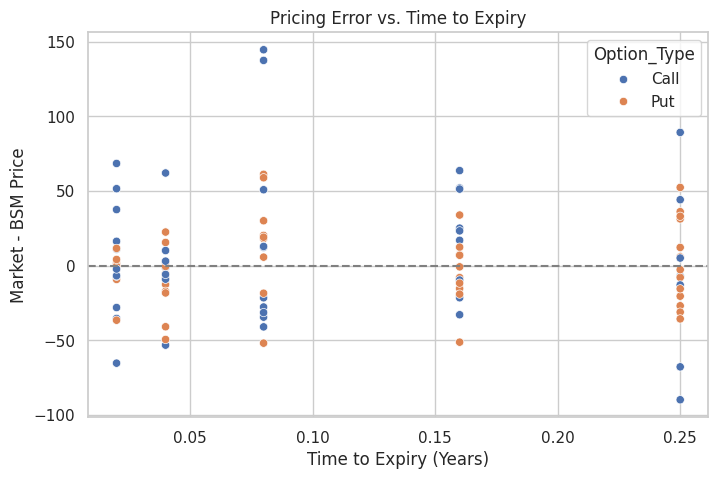

In [14]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Time_to_Expiry', y='Pricing_Error', hue='Option_Type', data=df)
plt.title('Pricing Error vs. Time to Expiry')
plt.xlabel('Time to Expiry (Years)')
plt.ylabel('Market - BSM Price')
plt.axhline(0, linestyle='--', color='gray')
plt.show()


In [15]:
summary_table = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE', 'R² Score'],
    'Value': [rmse, mae, mape, r2]
})

summary_table.style.set_caption("Summary of Black-Scholes Model Performance")


,Metric,Value
0,RMSE,37.492780
1,MAE,26.674783
2,MAPE,4.271771
3,R² Score,0.992207


In [17]:
# add conclusion